# Modeling Crop Yield Anomaly
## Python modules

In [1]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [2]:
def str2bool(string):
    return string.lower() in ("yes", "true", "t", "1")

point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")

In [3]:
data_dir = here("data")
directory = here("data", "random_features", "summary")
today = date.today().strftime("%Y-%m-%d")
files = os.listdir(directory)
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
files = [f for f in files if not (bool(point_pattern.search(f)) & bool(wa_pattern.search(f)))]
len(files)

44

In [4]:
def model(params):
#########################################     SET PARAMS    #########################################
    file         = params
    f            = file.split(sep="_")
    satellite    = f[0]
    bands        = f[1].replace("bands-", "")
    country_code = f[2]
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "").split(sep="-")
    mns          = f[6].replace("mn-", "").split(sep="-")
    limit_months = str2bool(f[7].replace("lm-", ""))
    crop_mask    = str2bool(f[8].replace("cm-", ""))
    weighted_avg = str2bool(f[9].replace("wa-", ""))
    years        = range(int(yrs[0]), int(yrs[1])+1)
    month_range  = list(range(int(mns[0]), int(mns[1])+1))
    
    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold  = KFold()
    logo   = LeaveOneGroupOut()
    ridge  = Ridge() 
#########################################     READ DATA    #########################################
    fn = f"{directory}/{file}"
    features = pd.read_feather(fn)
     
    drop_cols = ['district', 'year', 'yield_mt', 'crop_perc']
            
    if weighted_avg:
        drop_cols.remove("crop_perc")
    else:
        pass

#########################################     CALCULATE ANOMALY   #########################################
    features['yield_mt'] = np.log10(features['yield_mt'] + 1)
    features.set_index(['year', 'district'], inplace=True)
    var_cols = features.columns
    features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
    features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################
    x_all = features.drop(drop_cols, axis = 1) 
    y_all = features.yield_mt
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)
    
#########################################     K-FOLD  CV   ###########################################
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    kfold_ridge_reg.fit(x_train, y_train)
    kfold_best_model = kfold_ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
    y_pred_train_k = kfold_best_model.predict(x_train)
    y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     LOGO ITERATOR   ###########################################
    logo_val_results   = []
    logo_train_results = []
    logo_test_results  = []

    for year in features.year.unique():
#########################################     LOGO SPLIT   ###########################################
        logo_x_train = features[features.year != year].drop(drop_cols, axis=1)
        logo_y_train = features[features.year != year].yield_mt.ravel()
        logo_g_train = features[features.year != year].year.ravel()
        logo_d_train = features[features.year != year].district.ravel()

        logo_x_test = features[features.year == year].drop(drop_cols, axis=1)
        logo_y_test = features[features.year == year].yield_mt.ravel()
        logo_g_test = features[features.year == year].year.ravel()
        logo_d_test = features[features.year == year].district.ravel()

#########################################     LOGO CV   ###########################################
        ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
        logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
        logo_ridge_reg.fit(logo_x_train, logo_y_train, groups=logo_g_train)
        logo_best_model = logo_ridge_reg.best_estimator_
        ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
        logo_val_predictions = cross_val_predict(logo_best_model, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo) 
        logo_train_pred = logo_best_model.predict(logo_x_train)
        logo_test_pred  = logo_best_model.predict(logo_x_test)

#########################################     LOGO RESULTS   ###########################################
        val_results   = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 
                         'observed': logo_y_train, 'predicted': logo_val_predictions}

        train_results = {'year': logo_g_train, 'district': logo_d_train,'split': 'train', 
                         'observed': logo_y_train, 'predicted': logo_train_pred}

        test_results  = {'year': logo_g_test, 'district': logo_d_test, 'split': 'test', 
                         'observed': logo_y_test, 'predicted': logo_test_pred}
        
        logo_val_results.append(val_results)
        logo_train_results.append(train_results)
        logo_test_results.append(test_results)

#########################################     EXPLODE RESULTS   ###########################################
    explode_cols = ['year', 'district', 'observed', 'predicted']
    val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
    train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
    test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)
    
    group_cols = ['year', 'district', 'split']
    val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
    train_summary = train_df.groupby(group_cols, as_index=False).mean()
    
#########################################     SAVE RESULTS    #########################################
    d = {
        'country': country_code,
        'satellite': satellite,
        'bands': bands,
        'num_features': num_features,
        'points': points, 
        'month_range': f'{min(month_range)}-{max(month_range)}',
        
        'limit_months': limit_months,
        'crop_mask': crop_mask,
        'weighted_avg': weighted_avg,
        
        'kfold_total_n': len(x_all),
        'kfold_train_n': len(x_train),
        'kfold_test_n' : len(x_test),
        
        'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
        'kfold_mean_of_val_R2s': kfold_ridge_reg.best_score_,
        'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
        'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
        'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,
        
        'kfold_train_R2': r2_score(y_train, y_pred_train_k),
        'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
        'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,
        
        'kfold_test_R2': r2_score(y_test, y_pred_test_k),
        'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
        'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,
        
        'logo_total_n': len(features),
        'logo_train_n': len(train_df),
        'logo_test_n' : len(test_df),    
        
        'logo_best_reg_param': list(logo_ridge_reg.best_params_.values())[0],      
        'logo_summary_val_R2': r2_score(val_summary.observed, val_summary.predicted),
        'logo_summary_val_r' : pearsonr(val_summary.observed, val_summary.predicted)[0],
        'logo_val_R2' : r2_score(val_df.observed, val_df.predicted),
        'logo_val_r'  : pearsonr(val_df.predicted, val_df.observed)[0],
        'logo_val_r2' : pearsonr(val_df.predicted, val_df.observed)[0] ** 2,
        
        'logo_summary_train_R2': r2_score(train_summary.observed, train_summary.predicted),
        'logo_summary_train_r' : pearsonr(train_summary.observed, train_summary.predicted)[0],
        'logo_train_R2': r2_score(train_df.observed, train_df.predicted),
        'logo_train_r' : pearsonr(train_df.predicted, train_df.observed)[0],
        'logo_train_r2': pearsonr(train_df.predicted, train_df.observed)[0] ** 2,
        
        'logo_test_R2': r2_score(test_df.observed, test_df.predicted),
        'logo_test_r' : pearsonr(test_df.predicted, test_df.observed)[0],
        'logo_test_r2': pearsonr(test_df.predicted, test_df.observed)[0] ** 2,
    }
    return pd.DataFrame(data=d, index=[0])

In [5]:
%%time     
##### With progress bar
workers = 44 ## os.cpu_count()
if __name__ == "__main__":
    output = []
    for result in p_tqdm.p_map(model, files, num_cpus=workers):
        output.append(result)
    results = pd.concat(output).reset_index(drop=True)
    today = date.today().strftime("%Y-%m-%d")
    file_name = f'anomaly_results_{today}.csv'
    print(f"Saving results as: {file_name}\n\n")           
    results.to_csv(here("data","results", file_name), index=False)

  0%|          | 0/44 [00:00<?, ?it/s]

Saving results as: anomaly_results_2022-12-07.csv


CPU times: user 690 ms, sys: 610 ms, total: 1.3 s
Wall time: 1h 31min 20s


In [54]:
#########################################     SET PARAMS    #########################################
file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True_wa-True_summary.feather'
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
logo   = LeaveOneGroupOut()
ridge  = Ridge() 
#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)
features['yield_mt'] = np.log10(features['yield_mt'] + 1)
drop_cols = ['year', 'crop_perc']

if weighted_avg:
    drop_cols.remove("crop_perc")
else:
    pass

#########################################    FEATURES SPLIT    #########################################
train_split, test_split = train_test_split(features, test_size=0.2, random_state=0)
train_split['split'], test_split['split'] = 'train', 'test'
features_split = pd.concat([train_split, test_split])

#########################################     CALCULATE ANOMALY   #########################################
drop_cols.append('district'), drop_cols.append('split') 
features_split.set_index(drop_cols, inplace=True, append=True)
features_split = features_split - features_split.groupby(['district', 'split'], as_index=True).transform('mean')
features_split.reset_index(level=drop_cols, drop=False, inplace=True)

#########################################    K-FOLD SPLIT    #########################################
train = features_split[features_split.split=='train']
test  = features_split[features_split.split=='test']
drop_cols.append('yield_mt') 

x_all = features_split.drop(drop_cols, axis=1)

x_train = train.drop(drop_cols, axis=1)
y_train = train.yield_mt

x_test  = test.drop(drop_cols, axis=1)
y_test  = test.yield_mt

#########################################     K-FOLD  CV   ###########################################
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)

In [55]:
# pd.DataFrame(kfold_ridge_reg.cv_results_)

In [56]:
r2_score(y_train, kfold_val_predictions)

0.40880753562936867

In [57]:
r2_score(y_test, y_pred_test_k)

0.044394951366939384

In [60]:
features_split = features_split[drop_cols]
features_split['prediction'] = kfold_best_model.predict(x_all)
features_split['kfold_cv_predictions'] = np.concatenate((kfold_val_predictions,  np.repeat(np.nan, len(test))))

features_split

,year,district,split,yield_mt,prediction,kfold_cv_predictions
34,2020,Chibombo,train,-0.022783,0.010874,0.022913
627,2019,Sinazongwe,train,-0.226232,-0.225516,-0.230306
592,2020,Serenje,train,0.045464,-0.015450,-0.027975
530,2021,Namwala,train,-0.052788,0.026866,0.036500
443,2015,Mporokoso,train,-0.015371,-0.012144,-0.025801
...,...,...,...,...,...,...
402,2019,Mkushi,test,-0.108517,-0.039193,NaN
266,2018,Kitwe,test,-0.025701,-0.031432,NaN
640,2014,Zambezi,test,0.077852,-0.000483,NaN
532,2014,Nchelenge,test,-0.007809,0.003091,NaN


In [64]:
suffix = file.replace('_summary.feather', '.csv')
summary_fn_pred = here('data', 'results', f'summary-anomaly-pred_k-fold-cv_{suffix}')
features_split.to_csv(summary_fn_pred, index=False)

In [65]:
summary_fn_pred

PosixPath('/home/computevmuser/crop-modeling/code/3_task_modeling/../../data/results/summary-anomaly-pred_k-fold-cv_landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True_wa-True.csv')

In [6]:
drop_cols.remove('split')

In [7]:
%%time
#########################################     LOGO ITERATOR   ###########################################
logo_val_results   = []
logo_train_results = []
logo_test_results  = []

for year in features.year.unique():

    #########################################     LOGO SPLIT   ###########################################
    train_feats  = features[features.year != year]
    logo_x_train = train_feats.drop(drop_cols, axis=1)
    logo_y_train = train_feats.yield_mt.ravel()
    logo_g_train = train_feats.year.ravel()
    logo_d_train = train_feats.district.ravel()

    test_feats  = features[features.year == year]
    logo_x_test = test_feats.drop(drop_cols, axis=1)
    logo_y_test = test_feats.yield_mt.ravel()
    logo_g_test = test_feats.year.ravel()
    logo_d_test = test_feats.district.ravel()
    
    for alpha in alphas.get('alpha'):
        logo_ridge_reg = Ridge(alpha=alpha)
        logo_val_predictions = cross_val_predict(logo_ridge_reg, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo)
        val_results = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 'alpha': alpha, 
                     'observed': logo_y_train, 'predicted': logo_val_predictions, 'test_year': year}
        logo_val_results.append(val_results)


CPU times: user 35min 37s, sys: 1h 53min 17s, total: 2h 28min 55s
Wall time: 2min 54s


In [8]:
explode_cols = ['year', 'district', 'observed', 'predicted']
val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols)
val_df.reset_index(drop=True, inplace=True)
val_df

,year,district,split,alpha,observed,predicted,test_year
0,2014,Chadiza,val,1.000000e-08,0.532411,0.836003,2013
1,2015,Chadiza,val,1.000000e-08,0.480458,0.568243,2013
2,2016,Chadiza,val,1.000000e-08,0.458853,0.337881,2013
3,2017,Chadiza,val,1.000000e-08,0.589161,0.418698,2013
4,2018,Chadiza,val,1.000000e-08,0.361592,0.490012,2013
...,...,...,...,...,...,...,...
88123,2016,Zambezi,val,1.000000e+08,0.435413,0.456453,2021
88124,2017,Zambezi,val,1.000000e+08,0.396279,0.456855,2021
88125,2018,Zambezi,val,1.000000e+08,0.418678,0.463481,2021
88126,2019,Zambezi,val,1.000000e+08,0.339436,0.472678,2021


In [9]:
def r2(df):
    return pd.Series(dict(r2 = r2_score(df.observed, df.predicted)))

In [10]:
alpha_r2 = val_df.groupby(['alpha']).apply(r2).reset_index()
max(alpha_r2.r2)

0.440430699051753

In [11]:
alpha_r2 = val_df.groupby(['alpha', 'year']).apply(r2).reset_index()
max(alpha_r2.r2)

0.6792474455509957

In [12]:
alpha_r2[alpha_r2.r2==max(alpha_r2.r2)]

,alpha,year,r2
65,0.1,2015,0.679247


In [13]:
alpha_r2[alpha_r2.r2==max(alpha_r2.r2)].alpha.values[0]

0.1

In [14]:
alpha_r2[alpha_r2.r2==max(alpha_r2.r2)].year.values[0]

2015

In [15]:
alpha_r2

,alpha,year,r2
0,1.000000e-08,2013,-0.664289
1,1.000000e-08,2014,-3.247761
2,1.000000e-08,2015,-0.398270
3,1.000000e-08,2016,-2.369918
4,1.000000e-08,2017,-3.371799
...,...,...,...
148,1.000000e+08,2017,-0.036601
149,1.000000e+08,2018,-0.038431
150,1.000000e+08,2019,-0.227748
151,1.000000e+08,2020,-0.001691


In [132]:
import matplotlib.pyplot as plt

(array([ 3.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  4.,
         3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  2.,  0.,  1.,
         0.,  1.,  4.,  0.,  1.,  1.,  0.,  5.,  1.,  0.,  5.,  2.,  5.,
        12.,  4., 28.,  7.,  9.,  5., 11.,  9.,  8.,  8.,  2.]),
 array([-3.37442658, -3.2933531 , -3.21227962, -3.13120614, -3.05013266,
        -2.96905918, -2.8879857 , -2.80691222, -2.72583874, -2.64476525,
        -2.56369177, -2.48261829, -2.40154481, -2.32047133, -2.23939785,
        -2.15832437, -2.07725089, -1.99617741, -1.91510393, -1.83403045,
        -1.75295697, -1.67188349, -1.59081001, -1.50973653, -1.42866305,
        -1.34758957, -1.26651609, -1.18544261, -1.10436913, -1.02329564,
        -0.94222216, -0.86114868, -0.7800752 , -0.69900172, -0.61792824,
        -0.53685476, -0.45578128, -0.3747078 , -0.29363432, -0.21256084,
        -0.13148736, -0.05041388,  0.0306596 ,  0.11173308,  0.19280656,
         0.27388004,  0.35495352,  0.436027  ,  0.51710048,

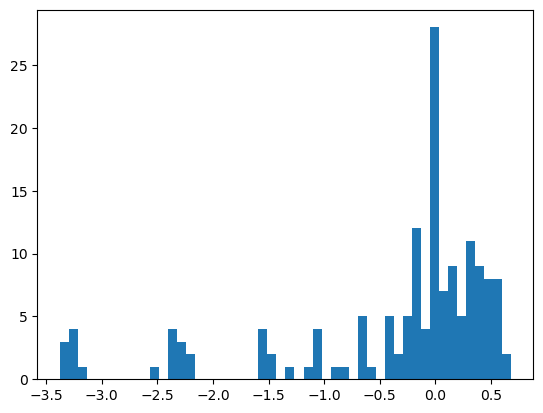

In [137]:
plt.hist(alpha_r2.r2, bins = 50)

In [32]:
#########################################     LOGO CV   ###########################################
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
logo_ridge_reg.fit(logo_x_train, logo_y_train, groups=logo_g_train)
logo_best_model = logo_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
logo_val_predictions = cross_val_predict(logo_best_model, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo) 
logo_train_pred = logo_best_model.predict(logo_x_train)
logo_test_pred  = logo_best_model.predict(logo_x_test)

#########################################     LOGO RESULTS   ###########################################
val_results   = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 
                 'observed': logo_y_train, 'predicted': logo_val_predictions}

train_results = {'year': logo_g_train, 'district': logo_d_train,'split': 'train', 
                 'observed': logo_y_train, 'predicted': logo_train_pred}

test_results  = {'year': logo_g_test, 'district': logo_d_test, 'split': 'test', 
                 'observed': logo_y_test, 'predicted': logo_test_pred}

logo_val_results.append(val_results)
logo_train_results.append(train_results)
logo_test_results.append(test_results)

#########################################     EXPLODE RESULTS   ###########################################
explode_cols = ['year', 'district', 'observed', 'predicted']
val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)

group_cols    = ['year', 'district', 'split']
val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
train_summary = train_df.groupby(group_cols, as_index=False).mean()

In [34]:
r2_score(val_df.observed, val_df.predicted)

0.44470098135261316

In [33]:
train_summary

,year,district,split,observed,predicted
0,2014,Chadiza,train,0.532411,0.614296
1,2014,Chama,train,0.541634,0.431853
2,2014,Chavuma,train,0.533827,0.445136
3,2014,Chibombo,train,0.552780,0.527682
4,2014,Chiengi,train,0.486234,0.475460
...,...,...,...,...,...
571,2021,Shangombo,train,0.243904,0.508038
572,2021,Siavonga,train,0.358978,0.508038
573,2021,Sinazongwe,train,0.237572,0.508038
574,2021,Solwezi,train,0.491828,0.508038


In [6]:
# #########################################     LOGO ITERATOR   ###########################################
# logo_val_results   = []
# logo_train_results = []
# logo_test_results  = []

# for year in features.year.unique():
# #########################################     LOGO SPLIT   ###########################################
#     logo_x_train = features[features.year != year].drop(drop_cols, axis=1)
#     logo_y_train = features[features.year != year].yield_mt.ravel()
#     logo_g_train = features[features.year != year].year.ravel()
#     logo_d_train = features[features.year != year].district.ravel()

#     logo_x_test = features[features.year == year].drop(drop_cols, axis=1)
#     logo_y_test = features[features.year == year].yield_mt.ravel()
#     logo_g_test = features[features.year == year].year.ravel()
#     logo_d_test = features[features.year == year].district.ravel()

# #########################################     LOGO CV   ###########################################
#     ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
#     logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
#     logo_ridge_reg.fit(logo_x_train, logo_y_train, groups=logo_g_train)
#     logo_best_model = logo_ridge_reg.best_estimator_
#     ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
#     logo_val_predictions = cross_val_predict(logo_best_model, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo) 
#     logo_train_pred = logo_best_model.predict(logo_x_train)
#     logo_test_pred  = logo_best_model.predict(logo_x_test)

# #########################################     LOGO RESULTS   ###########################################
#     val_results   = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 
#                      'observed': logo_y_train, 'predicted': logo_val_predictions}

#     train_results = {'year': logo_g_train, 'district': logo_d_train,'split': 'train', 
#                      'observed': logo_y_train, 'predicted': logo_train_pred}

#     test_results  = {'year': logo_g_test, 'district': logo_d_test, 'split': 'test', 
#                      'observed': logo_y_test, 'predicted': logo_test_pred}

#     logo_val_results.append(val_results)
#     logo_train_results.append(train_results)
#     logo_test_results.append(test_results)

# #########################################     EXPLODE RESULTS   ###########################################
# explode_cols = ['year', 'district', 'observed', 'predicted']
# val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
# train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
# test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)

# group_cols    = ['year', 'district', 'split']
# val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
# train_summary = train_df.groupby(group_cols, as_index=False).mean()

In [19]:
#########################################     SAVE RESULTS    #########################################
d = {
    'country': country_code,
    'satellite': satellite,
    'bands': bands,
    'num_features': num_features,
    'points': points, 
    'month_range': f'{min(month_range)}-{max(month_range)}',

    'limit_months': limit_months,
    'crop_mask': crop_mask,
    'weighted_avg': weighted_avg,

    # 'kfold_total_n': len(x_all),
    # 'kfold_train_n': len(x_train),
    # 'kfold_test_n' : len(x_test),

    'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
    'kfold_mean_of_val_R2s': kfold_ridge_reg.best_score_,
    'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
    'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
    'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,

    'kfold_train_R2': r2_score(y_train, y_pred_train_k),
    'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
    'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,

    'kfold_test_R2': r2_score(y_test, y_pred_test_k),
    'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
    'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,

#     'logo_total_n': len(features),
#     'logo_train_n': len(train_df),
#     'logo_test_n' : len(test_df),    

#     'logo_best_reg_param': list(logo_ridge_reg.best_params_.values())[0],      
#     'logo_summary_val_R2': r2_score(val_summary.observed, val_summary.predicted),
#     'logo_summary_val_r' : pearsonr(val_summary.observed, val_summary.predicted)[0],
#     'logo_val_R2' : r2_score(val_df.observed, val_df.predicted),
#     'logo_val_r'  : pearsonr(val_df.predicted, val_df.observed)[0],
#     'logo_val_r2' : pearsonr(val_df.predicted, val_df.observed)[0] ** 2,

#     'logo_summary_train_R2': r2_score(train_summary.observed, train_summary.predicted),
#     'logo_summary_train_r' : pearsonr(train_summary.observed, train_summary.predicted)[0],
#     'logo_train_R2': r2_score(train_df.observed, train_df.predicted),
#     'logo_train_r' : pearsonr(train_df.predicted, train_df.observed)[0],
#     'logo_train_r2': pearsonr(train_df.predicted, train_df.observed)[0] ** 2,

#     'logo_test_R2': r2_score(test_df.observed, test_df.predicted),
#     'logo_test_r' : pearsonr(test_df.predicted, test_df.observed)[0],
#     'logo_test_r2': pearsonr(test_df.predicted, test_df.observed)[0] ** 2,
}

In [20]:
pd.DataFrame(d, index = [0])

,country,satellite,bands,num_features,points,month_range,limit_months,crop_mask,weighted_avg,kfold_best_reg_param,kfold_mean_of_val_R2s,kfold_val_R2,kfold_val_r,kfold_val_r2,kfold_train_R2,kfold_train_r,kfold_train_r2,kfold_test_R2,kfold_test_r,kfold_test_r2
0,ZMB,landsat-8-c2-l2,1-2-3-4-5-6-7,1000,20,4-9,True,True,True,0.1,0.391126,0.408808,0.655647,0.429873,0.751895,0.870078,0.757035,0.044395,0.394147,0.155352
